In [4]:
# General imports
import numpy as np
import pylab as plt
from scipy.interpolate import interp1d
from scipy.special import zeta
from enum import Enum

import imageio
import os
from IPython.display import Image

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'serif': ['cmr10']})

import matplotlib as mpl
mpl.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'

In [5]:
# Choose Gamma and m_nuL here
Gamma = 244.87
m_nuL = 0.03
is_ncdm_decay_degenerate = "yes" #choose between "yes" or "no"
neutrino_hierarchy = "normal"    #choose between "normal" or "inverted"
decay_mass_gap = "atmospheric"   #choose between "atmospheric" or "solar"

Here we try some analytical estimates in order to guess in advance what is a good choice for qmax amd Nq given the values of Gamma,m_nuL, mass gap dor decay, etc

In [6]:
# Compute some quantities that we will need later
_k_B_        = 1.3806504e-23
_eV_         = 1.602176487e-19
_c_          = 2.99792458e8 
T_cmb        = 2.7255
T_ncdm_ratio = 0.71611
H0           = 67.5
Omega_m      = 0.3146
Delta_m2_atmos = 2.5e-3
Delta_m2_solar = 7.5e-5

def round_up_to_multiple_of_5(num):
    return ((num + 4) // 5) * 5

def get_Nq_and_qmax(Gamma,m_nuL,is_ncdm_decay_degenerate="yes",neutrino_hierarchy="normal",decay_mass_gap="atmospheric"):

    if decay_mass_gap == "atmospheric":
        Delta_m2 = Delta_m2_atmos
    else:
        Delta_m2 = Delta_m2_solar

    m_nuH = np.sqrt(m_nuL**2 + Delta_m2)
    # change to CLASS units
    m_nuH_rescaled = m_nuH*_eV_/(_k_B_*T_ncdm_ratio*T_cmb)
    m_nuL_rescaled = m_nuL*_eV_/(_k_B_*T_ncdm_ratio*T_cmb)

    a_NR = 3.15/m_nuH_rescaled 
    #Equivalent to eq. 6 in https://arxiv.org/pdf/1003.0942

    if is_ncdm_decay_degenerate == "yes" and neutrino_hierarchy == "normal":
        Gamma_rescaled = 2.*Gamma/H0
    else:
        Gamma_rescaled = Gamma/H0 
        
    if Gamma_rescaled > 1:
        a_decay = (1.+(-1.+Gamma_rescaled**2.)/Omega_m)**(-1./3.) 
    #This comes from setting Gamma/H(a)=1, assuming a M+Lambda universe for H(a) (i.e. neglect back-reaction of decay) 
    else:
        a_decay = 1. 
        
    if Gamma_rescaled > 9:
        a_decay2 = (1.+(-1.+(Gamma_rescaled/9.)**2.)/Omega_m)**(-1./3.) 
    #This comes from setting Gamma/H(a)=9, assuming a M+Lambda universe for H(a) (i.e. neglect back-reaction of decay) 
    else:
        a_decay2 = 1. 
    
    epsilon = Delta_m2/(2.*m_nuH**2.)
    q_prime_decay = a_decay*epsilon*m_nuH_rescaled
    q_prime_decay2 = a_decay2*epsilon*m_nuH_rescaled
    # Taken from eq. (5.6) in https://arxiv.org/pdf/2011.01502

    pref = np.sqrt(15.*zeta(5)/zeta(3))
    v_nuH_decay = pref/(a_decay2*m_nuH_rescaled) 
    # velocity dispersion of parent neutrino, expression taken from eq. 8 in https://arxiv.org/pdf/1003.0942
    # I use same expression as for stable neutrino, my guess is that for non-relat decays the exponential factor
    # should roughly cancel out in the numerator and denominator of the formula for the velocity 

    q_width_decay = a_decay*((m_nuH**2+m_nuL**2)/(2.*m_nuH**2))*m_nuH_rescaled*v_nuH_decay
    q_width_decay2 = a_decay2*((m_nuH**2+m_nuL**2)/(2.*m_nuH**2))*m_nuH_rescaled*v_nuH_decay
    # Taken from eq. 5.9 in https://arxiv.org/pdf/2011.01502

    q_max = q_prime_decay2+q_width_decay2

    if (q_max<15.): # if q is not injected above the qmax of the initial FD distib. (i.e. =15), then leave it to that value
        q_max = 15.
        
    # We want to evaluate Delta_q =(q1_+)-(q1_-), where (q1_+-) are the limits of the collision integral for the daughter
    # We choose to evaluate them at a=a_decay and q2 = 3.15 (average momentum of FD distribution)
    q2_avg = 3.15 
    eps2_avg_decay = np.sqrt(q2_avg**2+(a_decay*m_nuL_rescaled)**2)
    a = (eps2_avg_decay/2.)*(-1.+(m_nuH/m_nuL)**2)
    b = (q2_avg/2.)*(1.+(m_nuH/m_nuL)**2)

    if (a<b):
        Delta_q = 2.*a
    else:
        Delta_q = 2.*b

    # We impose that dq should be at least 4 times smaller than Delta_q, to resolve the collision integral correctly
    dq = 0.25*Delta_q
    if dq >1.5: #in any case, dq should never go significantly above 1, or numerical errors will be huge
        dq = 1.5
        
    Nq = q_max/dq    
    return round_up_to_multiple_of_5(q_max), round_up_to_multiple_of_5(Nq), a_NR, a_decay, a_decay2

q_max, Nq, a_NR, a_decay, a_decay2 = get_Nq_and_qmax(Gamma,m_nuL,is_ncdm_decay_degenerate,neutrino_hierarchy,decay_mass_gap)

print('q_max=',q_max)
print('Nq=',Nq)

q_max= 130.0
Nq= 90.0


Define function to read background phase-space distribution (PSD) of parent/daughter neutrinos computed by CLASS. We also store the values of rho and n at z=0. We also give the option to output snapshot of PSD only at z=0 or at various redshifts. 

In [7]:
def read_background(file_path, q_size_H, q_max_H, q_size_L, q_max_L, get_PSD_at_manyz = False,
                                                                     non_uniform_q = False,
                                                                     num_snapshots = 30):
    
    with open(file_path, 'r') as file:
        line_count = 0
        all_columns_bg = []

        for line in file:
            line_count += 1
            if line_count <= 4:
                continue

            columns = line.split()

            if len(all_columns_bg) == 0:
                all_columns_bg = [[] for _ in range(len(columns))]
            elif len(all_columns_bg) != len(columns):
                all_columns_bg.extend([] for _ in range(len(columns) - len(all_columns_bg)))

            for j, column_data in enumerate(columns):
                all_columns_bg[j].append(float(column_data))

    if is_ncdm_decay_degenerate == "yes":
        lnf_all = [all_columns_bg[18 + q_size_H + i] for i in range(q_size_L)]
    else:
        lnf_all = [all_columns_bg[21 + q_size_H + i] for i in range(q_size_L)]
    
    if get_PSD_at_manyz == False:
        lnf_s = [sublist[-1] for sublist in lnf_all]
    else:
        a_vector = np.array(all_columns_bg[1]) 
        H_vector = np.array(all_columns_bg[4]) 
        a_vector_NR = a_vector[a_vector>a_NR] #start recording PSD only when parent is non-relat, i.e. at a>a_NR
        idx_snapshots = np.linspace(len(a_vector)-len(a_vector_NR), len(a_vector)-1, num_snapshots, dtype=int,endpoint=True)
        a_snapshots = a_vector[idx_snapshots]
        H_snapshots = H_vector[idx_snapshots]*(_c_/1.e3)
        lnf_s = [np.array(sublist)[idx_snapshots] for sublist in lnf_all]
    
    lnf_d = np.array(lnf_s, dtype=float)
    pref = ((2 * np.pi)**3)/2 
    f_l = pref * np.exp(lnf_d)

    if is_ncdm_decay_degenerate == "yes":
        lnf_all = [all_columns_bg[15 + i] for i in range(q_size_H)]
    else:
        lnf_all = [all_columns_bg[18 + i] for i in range(q_size_H)]

    
    if get_PSD_at_manyz == False:
        a_vector = np.array(all_columns_bg[1]) 
        closest_idx_adecay = np.argmin(np.abs(a_vector - a_decay))
        lnf_s = [sublist[closest_idx_adecay] for sublist in lnf_all]
    else:
        lnf_s = [np.array(sublist)[idx_snapshots] for sublist in lnf_all]
        
    lnf_d = np.array(lnf_s, dtype=float)
    pref = ((2 * np.pi)**3)/2
    f_h = pref * np.exp(lnf_d)
    
    if non_uniform_q == False:
        step_H = q_max_H/q_size_H
        q_ratio_H = np.linspace(step_H, q_max_H, q_size_H, endpoint=True)

        step_L = q_max_L/q_size_L
        q_ratio_L = np.linspace(step_L, q_max_L, q_size_L, endpoint=True)
    else:
        N_low = int(0.6*q_size_H)
        N_high = q_size_H - N_low
        q_thres = round(0.35*q_max_H)
        step_1 = q_thres/N_low
        step_2 = (q_max_H-q_thres)/N_high
        x1 = np.linspace(step_1, q_thres, N_low, endpoint=True)
        x2 = np.linspace(q_thres+step_2, q_max_H, N_high,endpoint=True)  
        q_ratio_H = np.concatenate((x1, x2))

        N_low = int(0.6*q_size_L)
        N_high = q_size_L - N_low
        q_thres = round(0.35*q_max_L)
        step_1 = q_thres/N_low
        step_2 = (q_max_L-q_thres)/N_high
        x1 = np.linspace(step_1, q_thres, N_low, endpoint=True)
        x2 = np.linspace(q_thres+step_2, q_max_L, N_high,endpoint=True)  
        q_ratio_L = np.concatenate((x1, x2))

    
    q_int_H = np.linspace(q_max_H/1000, q_max_H, 1000)
    q_int_L = np.linspace(q_max_L/1000, q_max_L, 1000)

    if get_PSD_at_manyz == False:
        interp_func = interp1d(q_ratio_L, f_l, kind='cubic', fill_value='extrapolate')
        f_l = interp_func(q_int_L)
        interp_func1 = interp1d(q_ratio_H, f_h, kind='cubic', fill_value='extrapolate')
        f_h = interp_func1(q_int_H)
    else:
        f_l_snapshots = np.zeros((1000,num_snapshots))
        f_h_snapshots = np.zeros((1000,num_snapshots))
        for i in range(num_snapshots):
            interp_func = interp1d(q_ratio_L, f_l[:,i], kind='cubic', fill_value='extrapolate')
            f_l_snapshots[:,i] = interp_func(q_int_L)
            interp_func1 = interp1d(q_ratio_H, f_h[:,i], kind='cubic', fill_value='extrapolate')
            f_h_snapshots[:,i] = interp_func1(q_int_H)           
    
    if is_ncdm_decay_degenerate == "yes":
        n_nuL_0 = all_columns_bg[15 + q_size_H][-1]
        rho_nuL_0 = all_columns_bg[16 + q_size_H][-1]
    else:
        n_nuL_0 = all_columns_bg[18 + q_size_H][-1]
        rho_nuL_0 = all_columns_bg[19 + q_size_H][-1]        
   
    if get_PSD_at_manyz == False:
        return f_l,f_h,n_nuL_0,rho_nuL_0
    else:
        return f_l_snapshots,f_h_snapshots,a_snapshots,H_snapshots,n_nuL_0,rho_nuL_0

#Note: the factor ((2 * np.pi)**3)/2 is to compensate the factor 2/(2 * np.pi)**3) that is absorbed in the initial 
# value of the psd in CLASS

Here we plot an animation showing the evolution of the PSD

In [15]:
q_maxL = 70
NqL = 70
q_maxH = 70
NqH = 70

num_snapshots = 50

file_path = f"/Users/gfranco/class_repositories/CLASSpp_public_modified/output/testB1_g500_mL0p03_background.dat"

fl_snap,fh_snap,a_snap,H_snap,n_nuL0,rho_nuL0 = read_background(file_path, NqH, q_maxH, NqL, q_maxL,
                                                                get_PSD_at_manyz = True,
                                                                num_snapshots = num_snapshots)

q_intL = np.linspace(q_maxL/1000, q_maxL, 1000)
q_intH = np.linspace(q_maxH/1000, q_maxH, 1000)

In [18]:
#Create the GIF from the different PSD snapshots
output_folder = "PSD_snapshots"
os.makedirs(output_folder, exist_ok=True)
filenames = []

fontsize = 18
fontsize_title = 18
fontsize_tick = 14
power_q = 3

for i in range(num_snapshots):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6),sharey=True,dpi=150)
    plt.subplots_adjust(wspace=0)
        
    ax1.set_title(r'$\nu_H$',fontsize=fontsize_title,pad=10)
    ax2.set_title(r'$\nu_L$',fontsize=fontsize_title,pad=10)

    ax1.plot(q_intH, (q_intH**power_q)*fh_snap[:,i],color='purple')
    ax2.plot(q_intL, (q_intL**power_q)*fl_snap[:,i],color='green')
    
    ax1.set_xlim([q_intH[0],q_intH[-1]])
    ax2.set_xlim([q_intL[0],q_intL[-1]])
    ax1.set_ylim([-0.1,1.5])
    ax2.set_ylim([-0.1,1.5])

    ax1.set_xlabel(r'$q$', fontsize=fontsize)
    ax2.set_xlabel(r'$q$', fontsize=fontsize)
    ax1.set_ylabel(r'$q^%d \bar{f}_i(q)$'%power_q, fontsize=fontsize,labelpad=10)
    [x.set_linewidth(1.5) for x in ax1.spines.values()]
    [x.set_linewidth(1.5) for x in ax2.spines.values()]
    ax1.tick_params(axis='both', which='major',direction="out",labelsize=fontsize_tick,size=4)
    ax2.tick_params(axis='both', which='major',direction="out",labelsize=fontsize_tick,size=4)

#    ax1.text(30,1.15,r'$a$ = %.4f'%a_snap[i],fontsize=fontsize)
#    ax1.text(26.6,1.01,r'$\Gamma/H$ = %.4f'%(2*Gamma/H_snap[i]),fontsize=fontsize)
#    ax2.text(30,1.15,r'$a$ = %.4f'%a_snap[i],fontsize=fontsize)
#    ax2.text(26.6,1.01,r'$\Gamma/H$ = %.4f'%(2*Gamma/H_snap[i]),fontsize=fontsize)
    
    ax1.text(30,1.2,r'$a$ = %.4f'%a_snap[i],fontsize=fontsize)
    ax2.text(30,1.2,r'$a$ = %.4f'%a_snap[i],fontsize=fontsize)
    
#    ax1.annotate(r'Scenario B1, \ \ $\Gamma = %.0f$ km/s/Mpc, \ \ $m_{\nu l}= %.2f$  eV, \ \ $N_q$ = %d, \ \ $q_{\rm max}$ = %d '%(Gamma,m_nuL,Nq,q_max),
#            xy=(0.5, 0), xytext=(170, 413),
#            xycoords=('axes fraction', 'figure fraction'),
#            textcoords='offset points',
#            size=fontsize_title, ha='center', va='bottom')
    
    filename = f"{output_folder}/frame_{i}.png"
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()  # Close the plot to save memory

with imageio.get_writer("plot_PSD_evolution.gif", mode="I", duration=0.2) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

for filename in filenames:
    os.remove(filename)
os.rmdir(output_folder)

/Users/gfranco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  del sys.path[0]


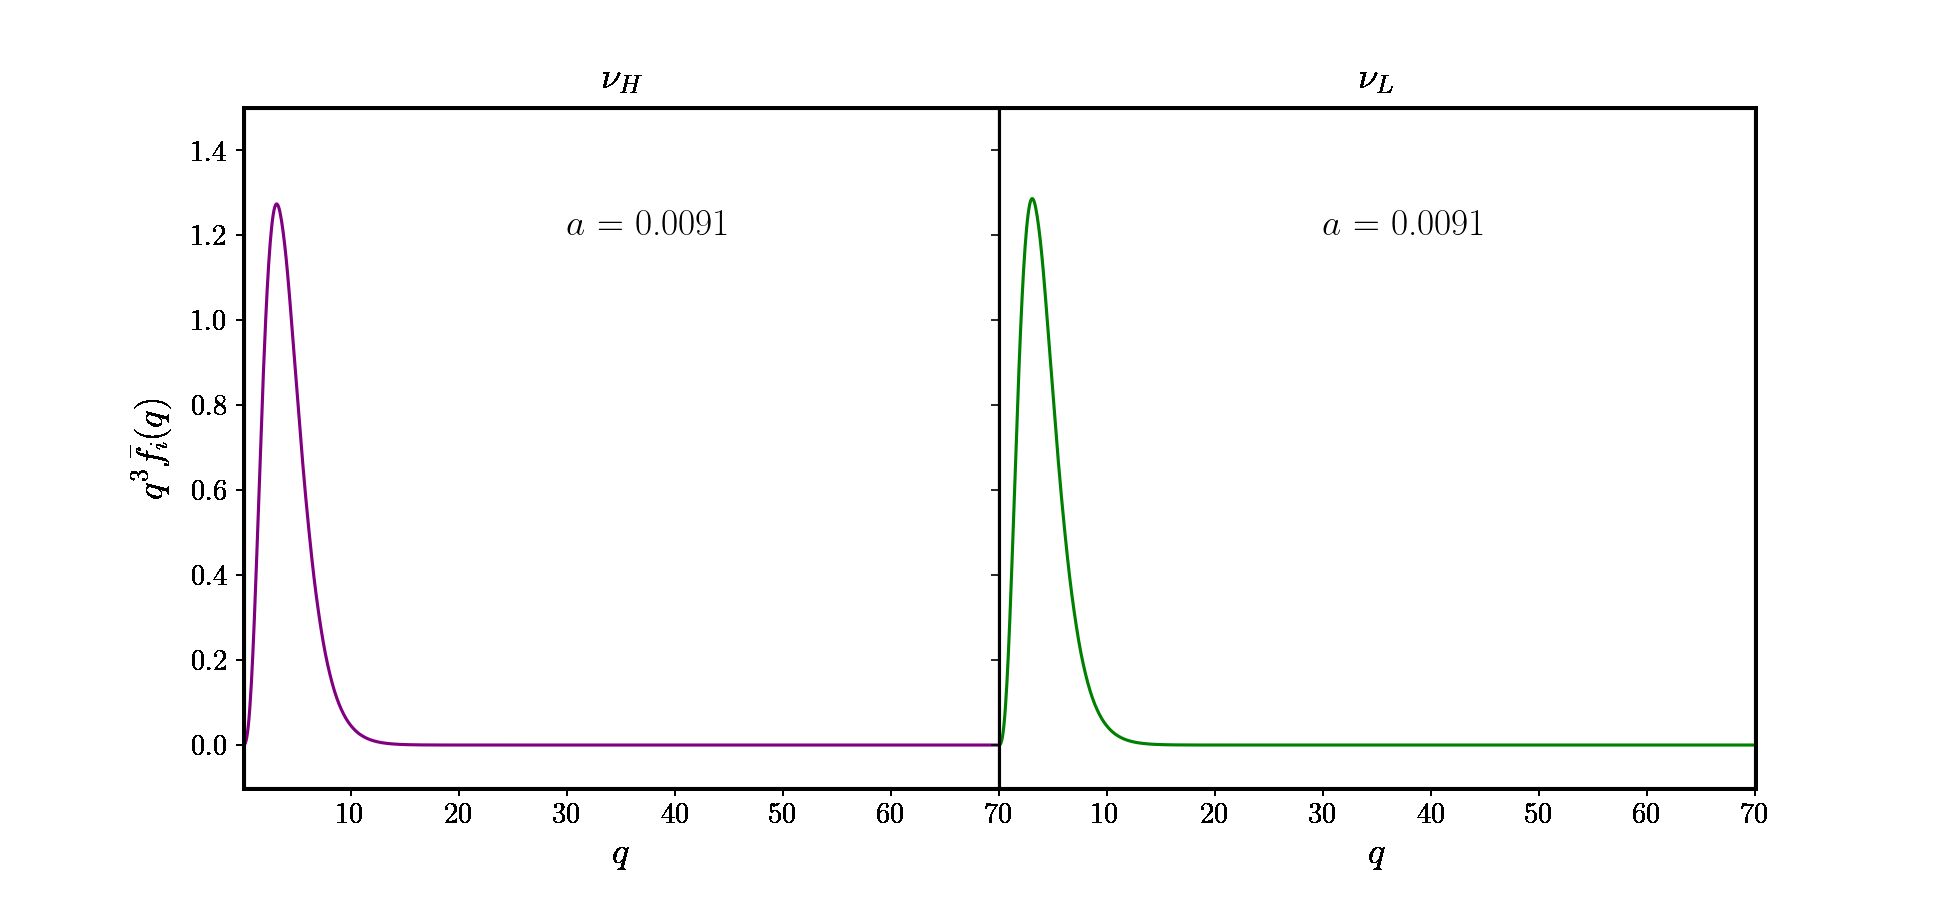

In [19]:
# plot the GIF
gif_path = "plot_PSD_evolution.gif"

Image(filename=gif_path)